In [89]:
import numpy as np
import emcee
import pandas as pd
import corner

import time
from multiprocessing import Pool

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [Zheng & Filippenko (2016)](https://arxiv.org/pdf/1612.02097.pdf), a broken power-law parameterization of SN Ia light curves is introduced. This parameterization is somewhat physically motivated, however, there are some assumptions that break down for some SNe Ia. A major advantage of this method, however, is that it covers the peak and turn-over of SN light curves, so there is no need to artificially truncate the data (to ~5 d after explosion for example) in order to only fit the early rise. 

The formulation is: 

$$L = A' \left(\frac{t - t_0}{t_b}\right)^{\alpha_\mathrm{r}} \left[1 + \left(\frac{t - t_0}{t_b}\right)^{s\alpha_\mathrm{d}}\right]^{-2/s}$$

which has a peak value when:

$$ t_p = t_b \times \left(-\frac{\alpha_1 + 1}{\alpha_2 + 1}\right)^{1/[s(\alpha_1 + \alpha_2)]} $$

and:

$$ \begin{align} \alpha_\mathrm{r} & = & 2(\alpha_1 + 1) \\ \alpha_\mathrm{d} & = & \alpha_1 - \alpha_2 \end{align}. $$

This parameterization has some additional constraints on the parameters, in particular, for $t \gg t_b$ if $\alpha_\mathrm{d} < \alpha_\mathrm{r}/2$ then the SN will not actually decline. $t_b$ is the break in the light curve, and is close to the rise time of the SN, assuming small $\alpha_1$ and $\alpha_2 \approx -2$.

In [10]:
def f_t(times, amplitude=25, t_b=20, t_0=0, alpha_r=2, alpha_d=2, s=2):
    return amplitude * ((times - t_0)/t_b)**alpha_r * ((1 + ((times - t_0)/t_b))**(s*alpha_d))**(-2/s)

1.5625


<IPython.core.display.Javascript object>


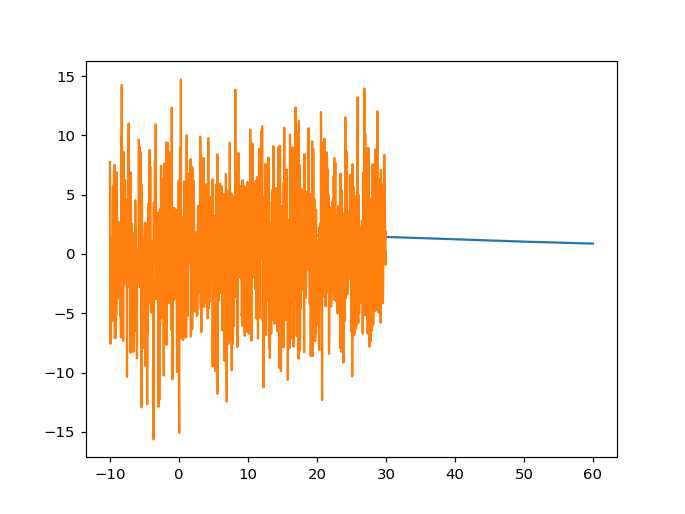

In [13]:
times = np.linspace(0,60,500)
flux = f_t(times)

print(f_t(20))

plt.plot(times, flux)

In [15]:
def lnlikelihood(theta, f, t, f_err):
    a, a_prime, t_0, t_b, alpha_r, alpha_d, s, sig_0 = theta

    pre_exp = np.logical_not(t > t_0)
    model = np.empty_like(f)
    model[pre_exp] = a
    
    time_term = (t[~pre_exp] - t_0)/t_b
    model[~pre_exp] = a_prime * (time_term)**alpha_r * (1 + (time_term)**(s*alpha_d))**(-2/s)
    
    ln_l = np.sum(np.log(1. / np.sqrt(2*np.pi * (sig_0**2 + f_err**2))) - ((f - model)**2 / (2 * (sig_0**2 + f_err**2))))
    return ln_l

#Define priors on parameters  
def lnprior(theta):
    a, a_prime, t_0, t_b, alpha_r, alpha_d, s, sig_0 = theta
    if (-100 < t_0 < 100 and 0 < alpha_r < 100 and 
        0 < alpha_d < 100 and 0 < sig_0 < 10000 and 
        -1000 < a < 1000 and  0 < t_b < 1000 and 
        0 < s < 1000 and 0 < a_prime < 1e6):
        return 0.0
    return -np.inf

def lnposterior(theta, f, t, f_err):
    lnp = lnprior(theta)
    lnl = lnlikelihood(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(lnp):
        return -np.inf
    return lnl + lnp 

In [90]:
def gen_zheng_lc(times, baseline=0, t_exp=0, alpha_r=2, 
                 alpha_d=2, s=2, t_b=18,
                 amplitude=2e4, sigma_sys=5):
    '''
    Generate a simple SN Ia-like light curve
    
    Parameters
    ----------
    
    times : array-like
        The times at which the simulated data should be generated.
        Times are in units of days.
    
    baseline : float, optional (default=0)
        The baseline value for the flux of the transient in the 
        telescope system.
    
    t_exp : float, optional (default=0)
        The time of explosion for the SN.
    
    alpha_r : float, optional (default=2)
        Power-law index for the initial rise of the SN.

    alpha_d : float, optional (default=2)
        Power-law index for the late time decay of the SN.
    
    s : float, optional (default=2)
        Smoothing parameter for the broken power-law model.

    amplitude : float, optional (default=2e4)
        Normalizing amplitude for the SN, the default value
        is determined by assuming all default parameters, 
        and a telescope system with 25 mag zeropoint.
    
    sigma_sys : float, optional (default=5)
        The systematic noise present in the light curves due to 
        the telescope system. The default value is determined from 
        assuming a telescope limiting magnitude of 21.5.
    
    Returns
    -------
    cnts : array-like, shape=shape(times)
        The counts corresponding to the SN flux, after taking into 
        account the noise associated with the detector
    
    cnts_unc : array-like, shape=shape(times)
        Uncertainty in the number of counts from the SN
    '''
    
    cnts = np.zeros_like(times)
    cnts_unc = np.zeros_like(times)

    pre_explosion = np.logical_not(times > t_exp)
    cnts[pre_explosion] = np.random.normal(baseline, sigma_sys, size=sum(pre_explosion))
    cnts_unc[pre_explosion] = np.ones_like(times)[pre_explosion]*sigma_sys

    time_term = (times[~pre_explosion] - t_exp)/t_b
    sn_flux = amplitude * (time_term)**alpha_r * (1 + (time_term)**(s*alpha_d))**(-2/s)
    sn_with_random_noise = sn_flux + np.random.normal(np.zeros_like(sn_flux), np.sqrt(sn_flux))
    sn_with_random_plus_sys = sn_with_random_noise + np.random.normal(baseline, sigma_sys, size=len(sn_flux))

    # total uncertainty = systematic + Poisson
    sn_uncertainties = np.hypot(np.sqrt(np.maximum(sn_with_random_noise, np.zeros_like(sn_with_random_noise))), 
                                sigma_sys)

    cnts[~pre_explosion] = sn_with_random_plus_sys
    cnts_unc[~pre_explosion] = sn_uncertainties

    return cnts, cnts_unc

In [102]:
t_obs=np.arange(-30,30)
cnts, cnts_unc = gen_zheng_lc(t_obs, sigma_sys=50)

In [103]:
# setup various emcee parameters

#initial guess on parameters
guess_0 = [0, 1e4, 0, 20, 2, 2, 1, 10]

#number of walkers
nwalkers = 100
nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
ndim = len(guess_0)
ncores=4

#initial position of walkers
pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

# light curve to fit
det = np.where(cnts/cnts_unc >= 4)
t_data = t_obs
f_data = cnts
f_unc_data = cnts_unc

#run initial burn-in
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data))
nsamples = 5000
foo = sampler.run_mcmc(pos, nsamples)

# run second burn in
burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
pos = [burn_max_post + nfac * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data), threads = ncores)
nsamples = 5000
foo = sampler.run_mcmc(pos, nsamples)

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


In [141]:
t_obs=np.arange(-30,30)
cnts, cnts_unc = gen_zheng_lc(t_obs, sigma_sys=50)
def sn_lc_mcmc(sigma_sys, t_obs):
    
    cnts, cnts_unc = gen_zheng_lc(t_obs, sigma_sys=sigma_sys)
    
    t_data = t_obs
    f_data = cnts
    f_unc_data = cnts_unc

    #initial guess on parameters
    guess_0 = [0, 1e4, 0, 20, 2, 2, 1, 10]

    #number of walkers
    nwalkers = 100
    nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
    ndim = len(guess_0)
    ncores=4

    #initial position of walkers
    pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data))
    nsamples = 500
    foo = sampler.run_mcmc(pos, nsamples)

    # run second burn in
    burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
    pos = [burn_max_post + nfac * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data), threads = ncores)
    nsamples = 1000
    foo = sampler.run_mcmc(pos, nsamples)
    
    return sampler

In [143]:
%%timeit
sampler = sn_lc_mcmc(200, t_obs)

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


8.86 s ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [144]:
import multiprocessing
from itertools import product
from functools import partial



In [145]:
%%timeit
t_obs=np.arange(-30,30)
pool = multiprocessing.Pool(4)
sampler1, sampler2, sampler3, sampler4 = pool.map(partial(sn_lc_mcmc, t_obs=t_obs), [3,5,50,316])

# pool.starmap(merge_names, product(names, repeat=2))

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountere

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountere

11.4 s ± 446 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [138]:
sampler1.flatchain

array([[-2.75479485e+01,  9.77023896e+03,  5.71246881e+00, ...,
         9.35777893e+01,  1.20997732e+01,  2.77354671e+02],
       [-2.75605273e+01,  9.77026684e+03,  5.70664073e+00, ...,
         9.36007835e+01,  1.20398424e+01,  2.77341014e+02],
       [-2.75760153e+01,  9.77024922e+03,  5.74455682e+00, ...,
         9.36026611e+01,  1.20887608e+01,  2.77347646e+02],
       ...,
       [ 2.27923518e+01,  1.13082589e+04,  6.73343699e+00, ...,
         4.29285995e+01,  5.52993269e+02,  7.66779503e+02],
       [ 7.82691677e+01,  1.07577767e+04,  6.41818843e+00, ...,
         3.91708767e+01,  7.30133662e+02,  9.74482455e+02],
       [ 1.52014769e+02,  1.07766205e+04,  6.90407062e+00, ...,
         5.20785651e+01,  1.75441776e+02,  7.79726200e+02]])

In [104]:
# set a "burn-in" limit
nburn = 3000

#Grab alpha and t_0 samples from all walkers
alpha_r_samples = np.array(sampler.chain[:,:nburn,4]).flatten()
alpha_d_samples = np.array(sampler.chain[:,:nburn,5]).flatten()
s_samples = np.array(sampler.chain[:,:nburn,6]).flatten()
t_0_samples = np.array(sampler.chain[:,:nburn,2]).flatten()
t_b_samples = np.array(sampler.chain[:,:nburn,3]).flatten()
a_samples = np.array(sampler.chain[:,:nburn,0]).flatten()
sig_0_samples = np.array(sampler.chain[:,:nburn,7]).flatten()
a_prime_samples = np.array(sampler.chain[:,:nburn,1]).flatten()
#print the median taking 1-sigma confidence intervals
samples = np.vstack([t_0_samples, t_b_samples, alpha_r_samples, alpha_d_samples, 
                     a_samples, a_prime_samples, s_samples, sig_0_samples]).T

In [105]:
t_0_mc, t_b_mc, alpha_r_mc, alpha_d_mc, a_mc, a_prime_mc, s_mc, sig_0_mc = map(lambda v: (v[0], v[1], v[2], v[3], v[4]), 
                                             zip(*np.percentile(samples, [2.5, 16, 50, 84, 97.5], axis=0)))
print("emcee results with 68% credible regions\n \
      t_0 = {:.4f} -{:.4f} +{:.4f}\n \
      t_b = {:.4f} -{:.4f} +{:.4f}\n \
      alpha_r = {:.4f} -{:.4f} +{:.4f}\n \
      alpha_d = {:.4f} -{:.4f} +{:.4f}\n \
      a = {:.4f} -{:.4f} +{:.4f}\n \
      a_prime = {:.4f} -{:.4f} +{:.4f}\n \
      s = {:.4f} -{:.4f} +{:.4f}\n \
      sig_0 = {:.4f} -{:.4f} +{:.4f}\n" \
      .format(t_0_mc[2], t_0_mc[2] - t_0_mc[1], t_0_mc[3] - t_0_mc[2], 
              t_b_mc[2], t_b_mc[2] - t_b_mc[1], t_b_mc[3] - t_b_mc[2],
              alpha_r_mc[2], alpha_r_mc[2] - alpha_r_mc[1], alpha_r_mc[3] - alpha_r_mc[2], 
              alpha_d_mc[2], alpha_d_mc[2] - alpha_d_mc[1], alpha_d_mc[3] - alpha_d_mc[2], 
              a_mc[2], a_mc[2] - a_mc[1], a_mc[3] - a_mc[2],
              a_prime_mc[2], a_prime_mc[2] - a_prime_mc[1], a_prime_mc[3] - a_prime_mc[2],
              s_mc[2], s_mc[2] - s_mc[1], s_mc[3] - s_mc[2],
              sig_0_mc[2], sig_0_mc[2] - sig_0_mc[1], sig_0_mc[3] - sig_0_mc[2]))

emcee results with 68% credible regions
       t_0 = -53.7010 -0.0296 +0.0195
       t_b = 17.1338 -0.0357 +0.0277
       alpha_r = 35.9105 -0.0328 +0.0387
       alpha_d = 2.2195 -0.0289 +0.0333
       a = -15.3308 -0.0363 +0.0309
       a_prime = 9910.2317 -0.0379 +0.0419
       s = 3.4600 -0.0491 +0.0399
       sig_0 = 11.1058 -0.0350 +0.0270



<IPython.core.display.Javascript object>


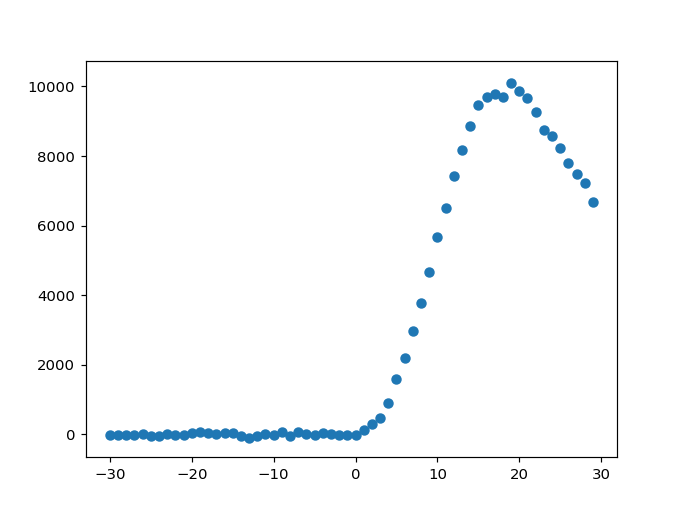

<ErrorbarContainer object of 3 artists>

In [106]:
plt.figure()
plt.errorbar(t_obs, cnts, cnts_unc, fmt='o')

<IPython.core.display.Javascript object>


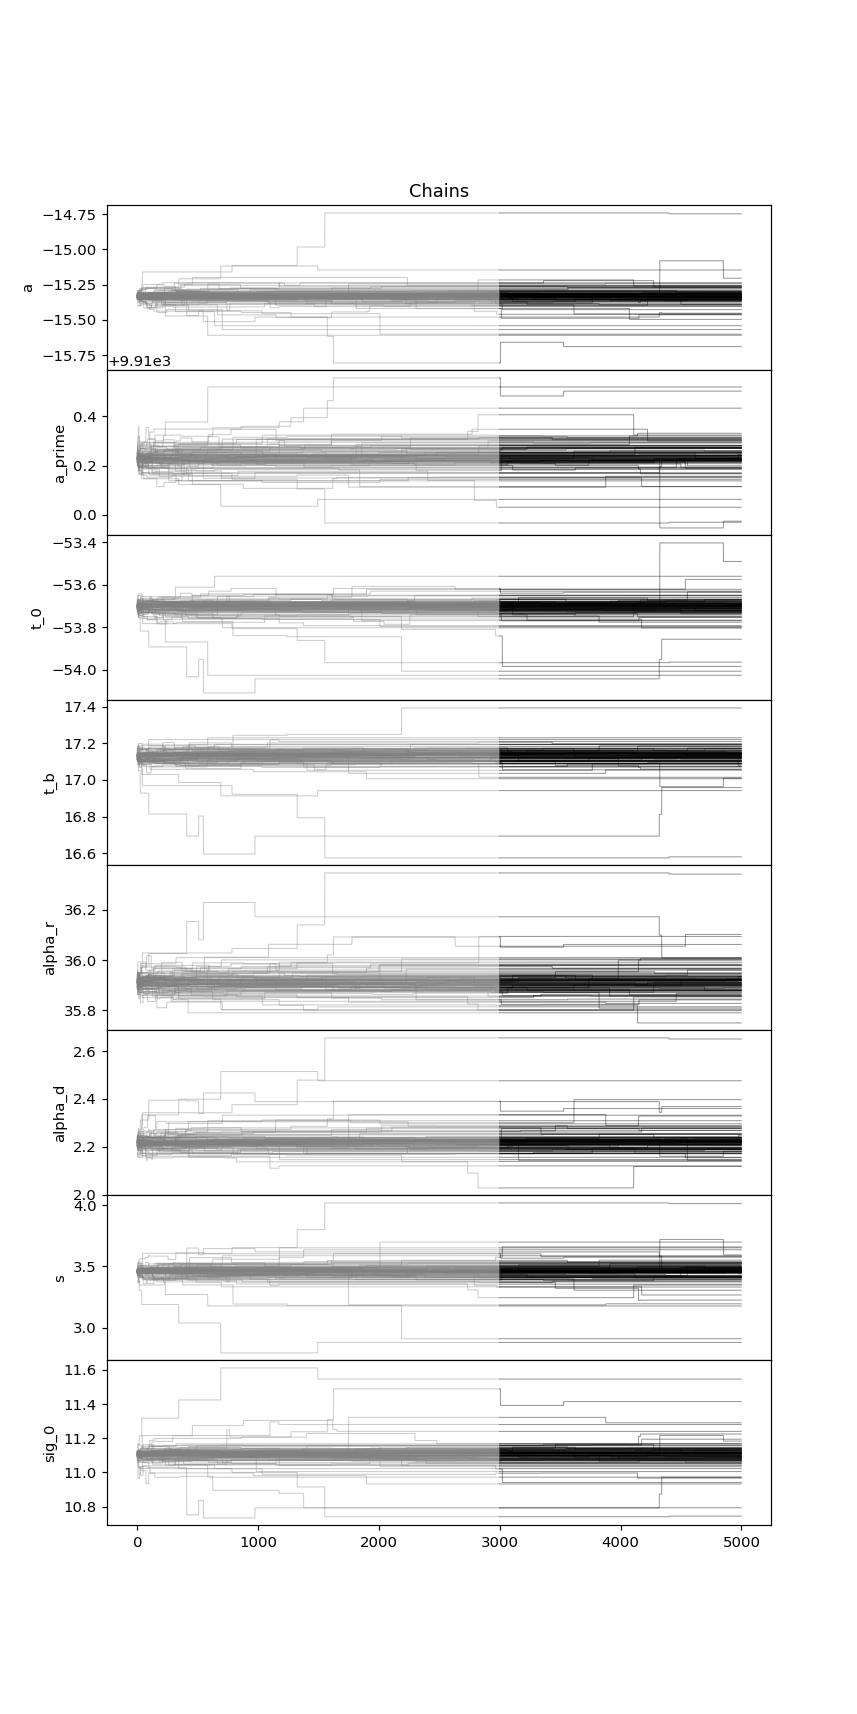

In [107]:
ax = plotChains(sampler, nburn, paramsNames)
plt.show()

<IPython.core.display.Javascript object>


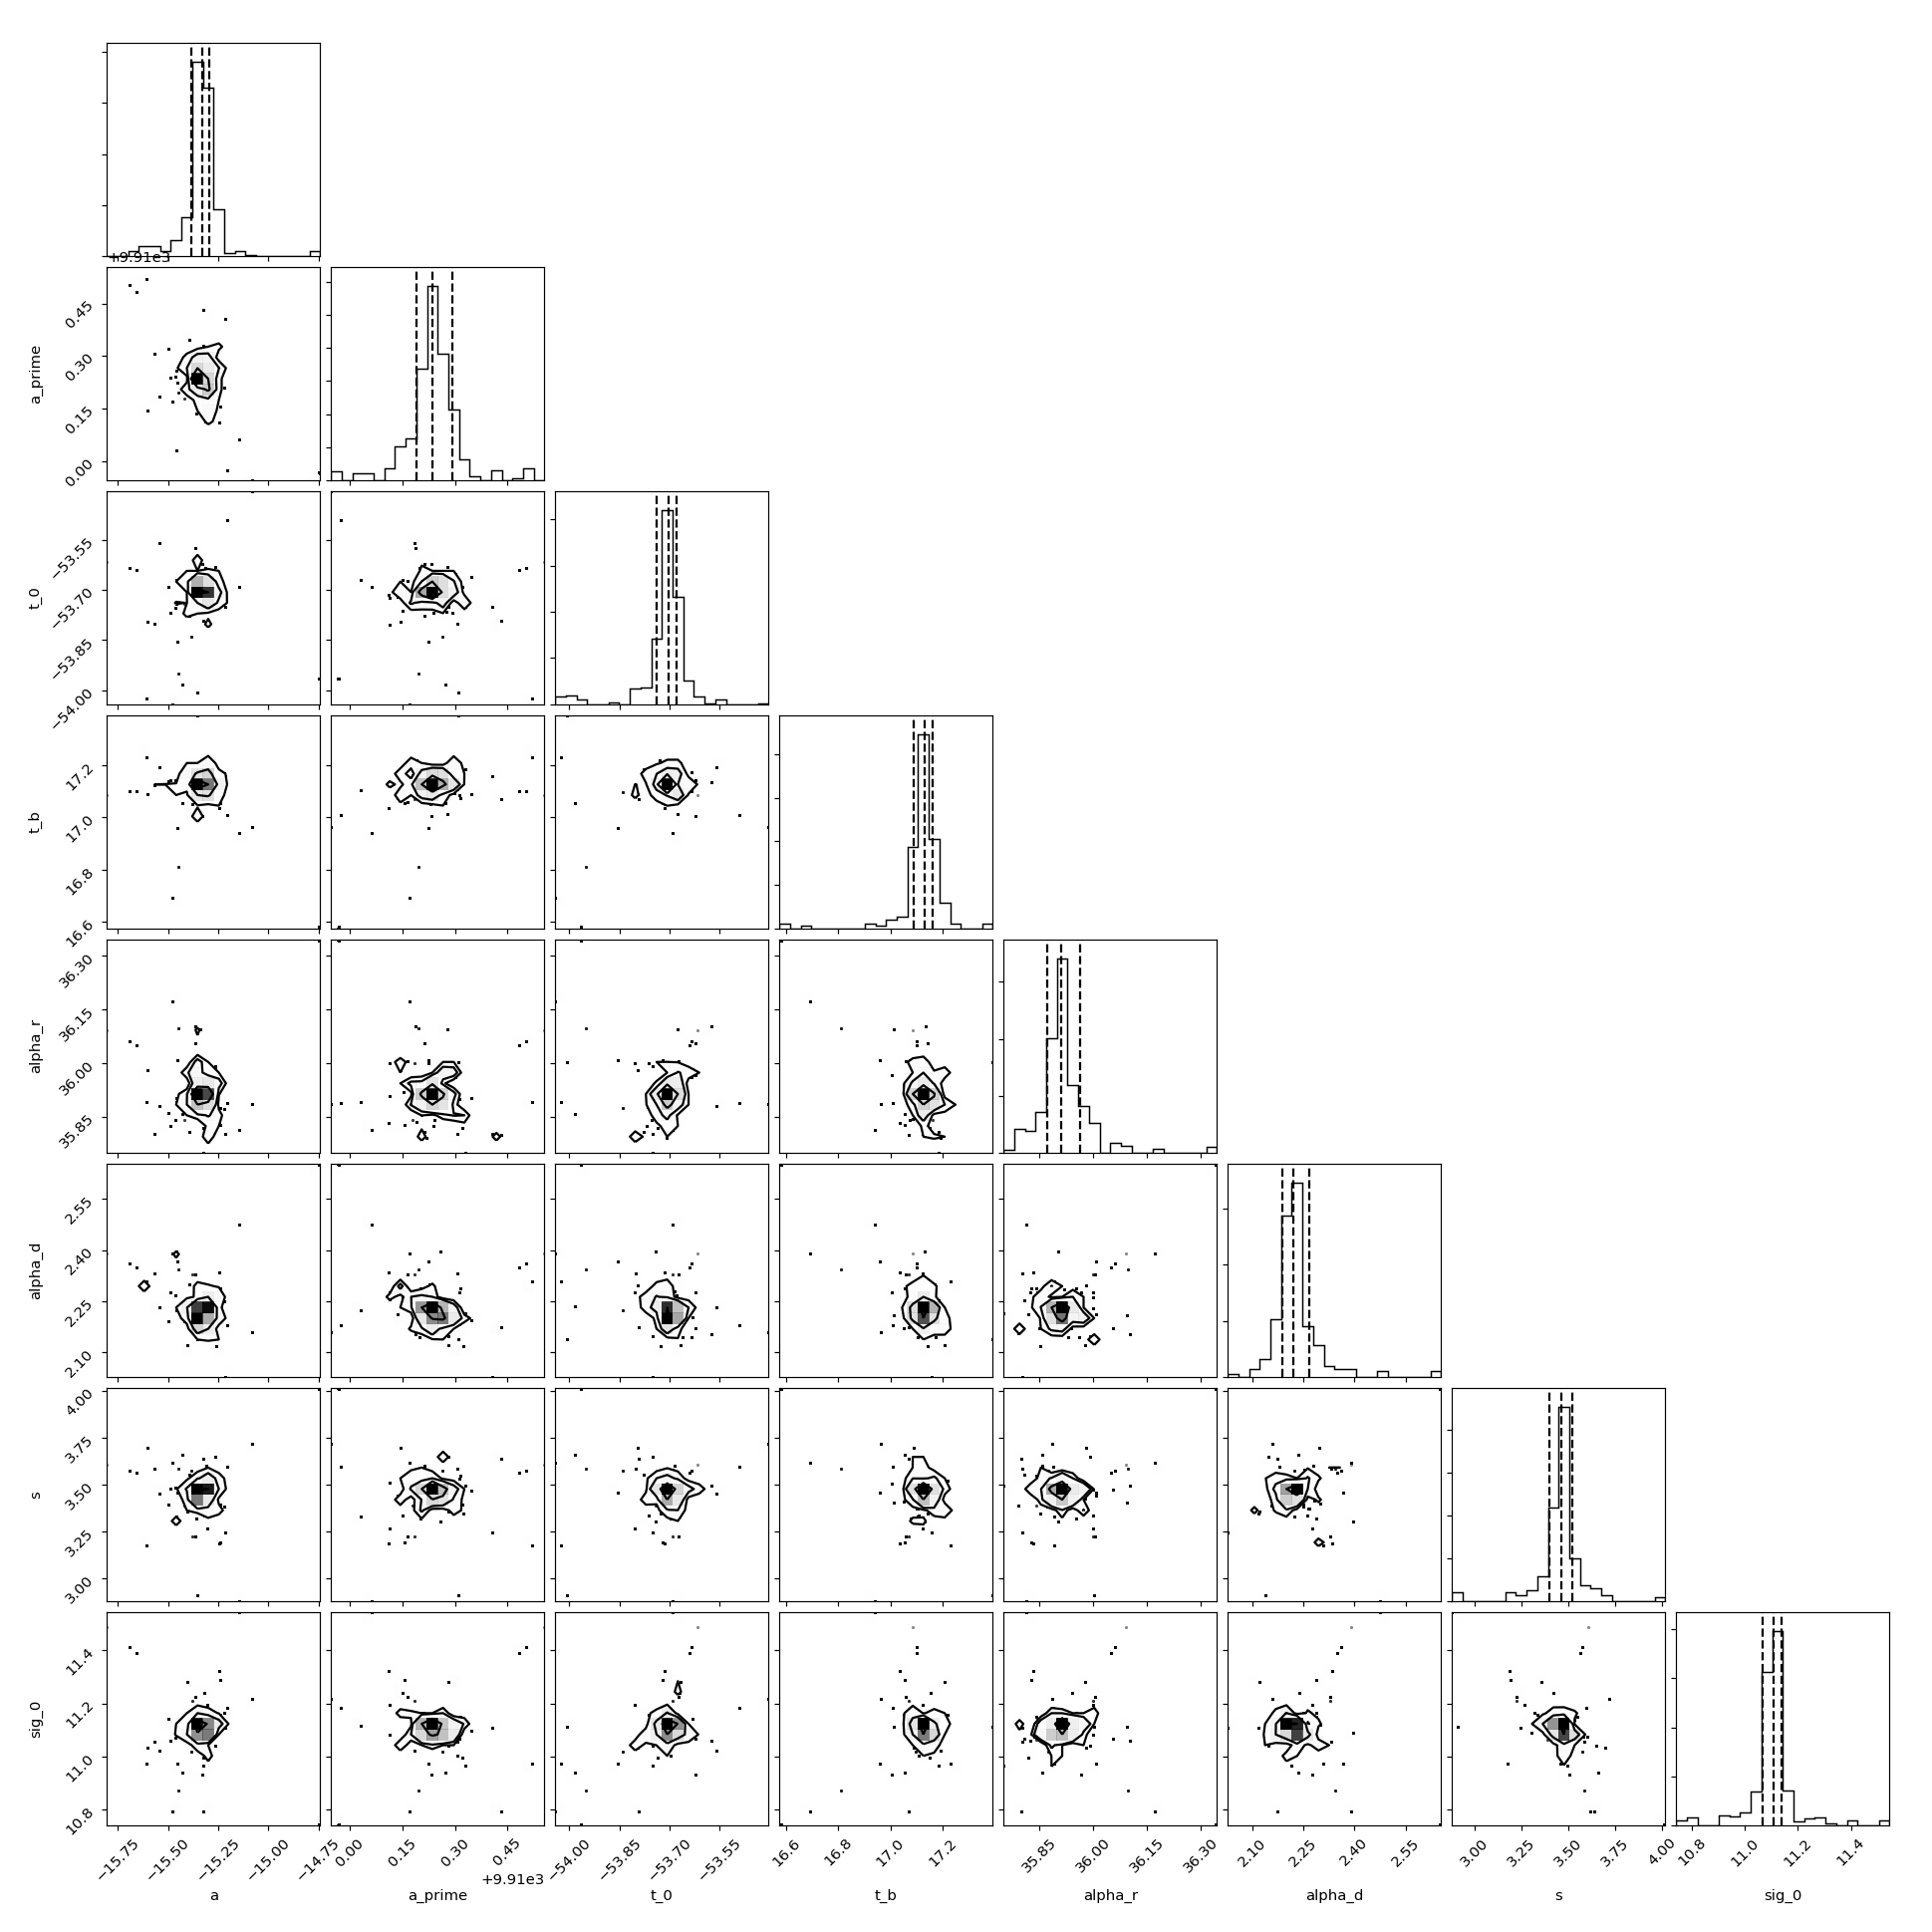

In [108]:
makeCorner(sampler, nburn, paramsNames)
plt.show()

In [91]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84]):
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
    f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, )
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax

paramsNames=['a', 'a_prime', 't_0', 't_b', 'alpha_r', 'alpha_d', 's', 'sig_0']